# Healthcare Stroke Prediction
24/07/2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


In [2]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv.xls")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Data Preprocessing

In [3]:
df.drop(["id"] ,axis=1, inplace=True)
df.drop_duplicates(inplace=True)


In [4]:
df.isnull().sum()


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# bmi is numerical, we can replace with the mean
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())


In [6]:
df.drop(df[df['gender'] == "Other"].index, axis=0, inplace=True)


In [7]:
numerical = list(df.select_dtypes(exclude="O").columns)
print(numerical)

df[numerical].head(10)


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.600000,1
1,61.0,0,0,202.21,28.893237,1
2,80.0,0,1,105.92,32.500000,1
3,49.0,0,0,171.23,34.400000,1
4,79.0,1,0,174.12,24.000000,1
5,81.0,0,0,186.21,29.000000,1
6,74.0,1,1,70.09,27.400000,1
7,69.0,0,0,94.39,22.800000,1
8,59.0,0,0,76.15,28.893237,1
9,78.0,0,0,58.57,24.200000,1


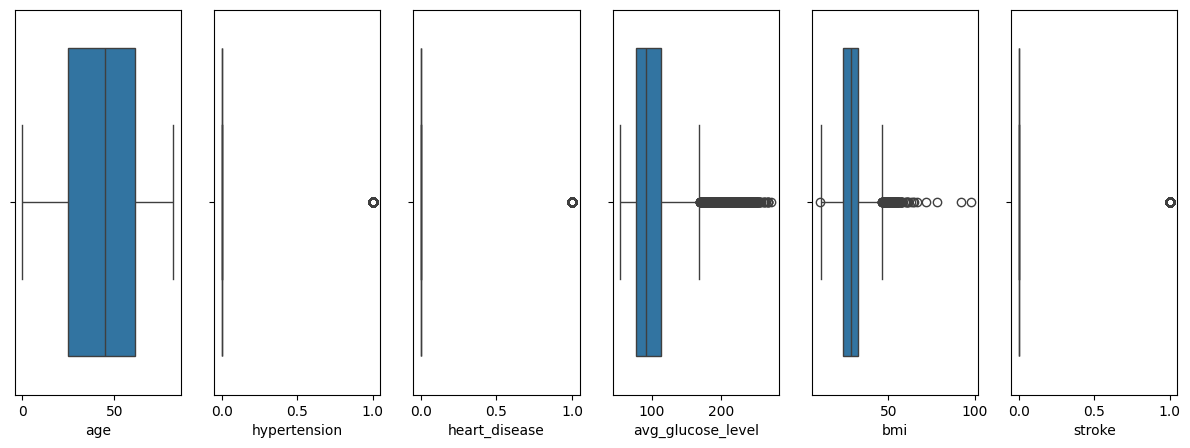

In [8]:
plt.figure(figsize=(15, 5))
for i in range(len(numerical)):
    plt.subplot(1, len(numerical), i + 1)
    sns.boxplot(x=df[numerical[i]])
plt.show()


In [9]:
categorical = list(df.select_dtypes(include="O").columns)
categorical


['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
<ipython-input-10-d19408419019>:8: UserWarning: FixedFormatter should only be us

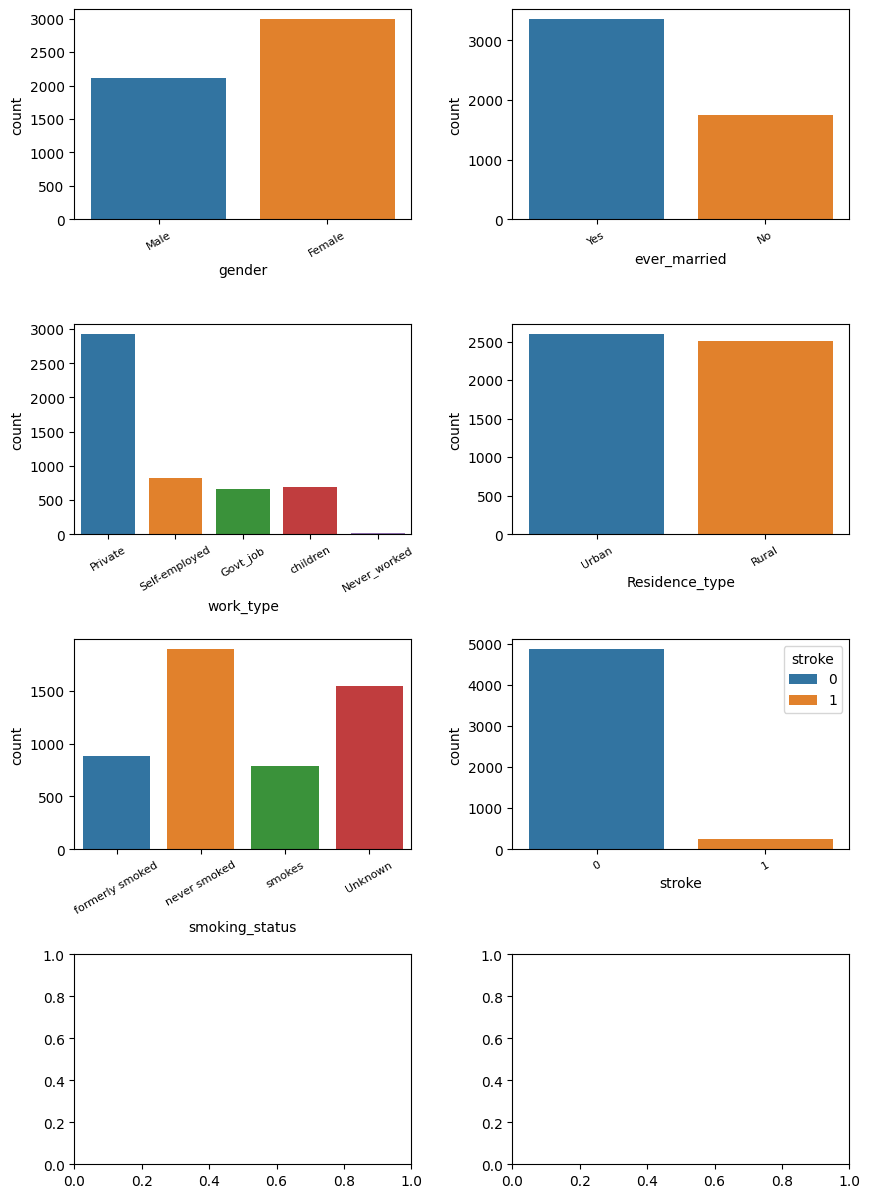

In [10]:
figure, axis = plt.subplots(4, 2, figsize=(10, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, column_name in enumerate(categorical + ['stroke']):
    row = i // 2
    col = i % 2
    barplot = sns.countplot(ax=axis[row, col], x=df[column_name], hue=df[column_name])
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30, size=8)
plt.show()


In [11]:
label_encoder = LabelEncoder()
for col in categorical:
    df[col] = label_encoder.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   int64  
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int64  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 479.0 KB


### Modeling and testing

In [12]:
X = df.drop(columns=['stroke'])
y = df['stroke']


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)


#### Decision Tree

In [15]:
tree_model = DecisionTreeClassifier(criterion='entropy')
tree_model.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy')

In [16]:
y_pred = tree_model.predict(X_test)
accuracy_score(y_test, y_pred)


0.9099804305283757

#### Logistic Regression

In [17]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


LogisticRegression()

In [18]:
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred)


0.9393346379647749

#### Random Forest Classifier

In [19]:
rf_model = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state=123)
rf_model.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=123)

In [20]:
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)


0.9383561643835616

### Conclusion:
The best fitting model from DecisionTree, LogisticRegression, and RandomForestClassifier is the LogisticRegression based on the accuracy result.